# AI Generated Heatmaps 

Generating complex heatmaps with multiple sources are compute intensive algorithms. Often, one must iterate through every pixel in the space, and sum the computed rolled off intensities of every "source" in the space at each pixel location. Typical heatmap algorithms also have a fixed diffusion computation (such as inverse square law) and do not learn actual spatial relationships for intensity / distance. More importantly, there are no off-the-shelf algorithms for modeling diffusion patterns of different IEQ analytes in arbitrary interior spaces. We propose that a Neural Network can learn these patterns and then generate heatmaps from sparse inputs containing measured intensities at known spatial locations. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [16]:
def get_sparse_matrix(m, n, s):
    """In our case, a sparse matrix is a matrix composed mostly of zeros
        with the source intensities representing the non-zero values
        m x n is the output matrix size
        s is a list of 'sources' [[intensity_0, x_0, y_0],[intensity_1, x_1, y_1],...]
    """
    matrix = np.zeros((m, n))
    for i in range(s.shape[0]):
        matrix[int(s[i][1])][int(s[i][2])] = s[i][0]

    return matrix

def intensity_from_source(target_x, target_y, source_intensity, source_x, source_y):
    """compute the inverse squared intensity"""
    distance = np.sqrt((source_x - target_x) ** 2 + (source_y - target_y) ** 2)
    if distance == 0:  # Prevent division by zero
        return source_intensity
    return source_intensity / (distance ** 2)

def intensity_matrix(m, n, sources):
    """build a heatmap of m x n size from a list of 'sources' """
    matrix = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for source in sources:
                source_intensity, source_x, source_y = source
                matrix[i][j] += intensity_from_source(i, j, source_intensity, source_x, source_y)
    return matrix

253.06064601186551 250.0


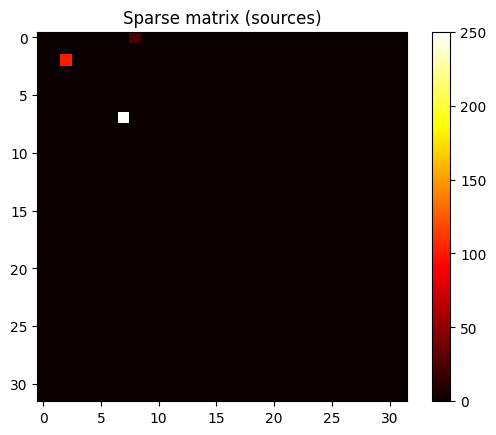

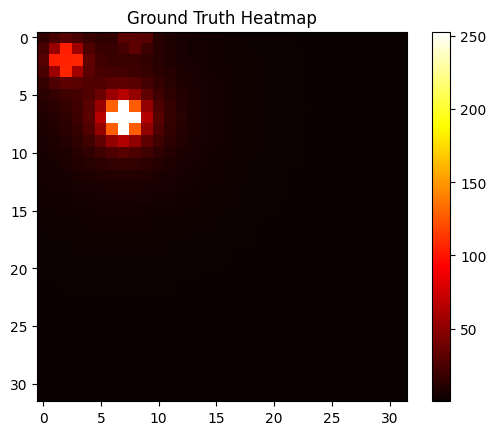

In [17]:
test_sources = np.array([[100, 2, 2], [250, 7, 7], [23, 0, 8]])

test_dim = 32
# Create a ground truth heatmap
ground_truth_heatmap = intensity_matrix(test_dim, test_dim, test_sources)
test_source_sparse = get_sparse_matrix(test_dim, test_dim, test_sources)

print(ground_truth_heatmap.max(), test_source_sparse.max())

# Visualization
plt.imshow(test_source_sparse, cmap='hot', interpolation='nearest')
plt.title("Sparse matrix (sources)")
plt.colorbar()
plt.show()

plt.imshow(ground_truth_heatmap, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

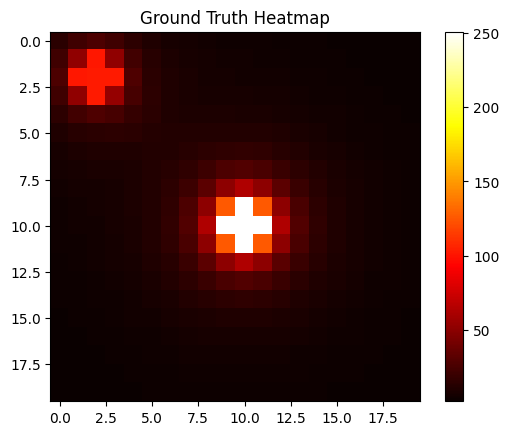

In [18]:
ground_truth_heatmap2 = intensity_matrix(20, 20, [(100, 2, 2), (250, 10, 10), (2, 4, 4)])
plt.imshow(ground_truth_heatmap2, cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

Assume we have a fixed number of sensors in a space and we're developing a model based on survey data. Our survey data should be based on fixed snapshots from each sensor (source) at a given point of time, and given those values, we survey a coordinate / X value. We can simulate what an open space heatmap / diffusion looks like with the above code. 

In [141]:
heatmap_w, heatmap_h = 32, 32
num_heatmaps = 10000
random_positions = True

def generate_dataset_sparse(m, n, num_heatmaps=1000, random_pos=False):

    intensity_range = (0,1000)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    sparse_matrices = np.zeros((num_heatmaps, m, n))

    for i in range(num_heatmaps):
        
        sources = np.array([[0, 10, 10], [0, 12, 14], [0, 20, 20]])
        
        for k in range(len(sources)):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity

            if random_pos is True:
                x = random.randrange(m)
                y = random.randrange(n)

                sources[k][1] = x
                sources[k][2] = y

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        sparse_matrices[i] = get_sparse_matrix(m, n, sources)

        # print(heatmap_matrices[i].max(), sparse_matrices[i].max())
        
    return sparse_matrices, heatmap_matrices

Most modern machines support multiprocessing / multicore. For example: my core i9 has 24 cores. Running the dataset generation on a single core takes minutes. 

Using multiprocessing on all 24 cores takes ~10 seconds. 

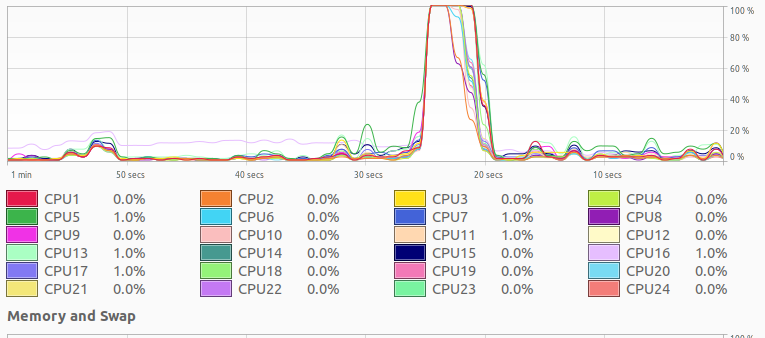

In [142]:
def gen_dset_sparse_wrapper(params_dict):
    Xs, Ys = generate_dataset_sparse(params_dict['m'], params_dict['n'], params_dict['num_heatmaps'], params_dict['random_pos'])
    return (Xs, Ys)

def gen_dataset_multicore(m, n, num_heatmaps, random_pos):
    """ multiprocessing version to accelerate test data creation
        DO NOT call this function unless the number of samples you need is 
        at least 10 times greater than the number of cores you have
    """
    # running this data generator on one CPU core is painful 
    import multiprocessing
    from multiprocessing import Pool
    cpu_count = multiprocessing.cpu_count()
    
    # Print the number of CPU cores available on the system.
    print("Number of cores available:{}".format(cpu_count))
    
    cpu_count = int(cpu_count)

    # we will end up with a few over / under
    n_heatmaps_per_core = int(num_heatmaps / cpu_count)

    params_dict = {"m": m, "n": n, "num_heatmaps": n_heatmaps_per_core, "random_pos": random_pos}
    
    with Pool(cpu_count) as pool:
        #known_words = set(pool.map(hash_word, words))
        all_datasets = list(pool.map(gen_dset_sparse_wrapper, [params_dict for i in range(cpu_count)]))

    Xs = np.zeros((n_heatmaps_per_core * cpu_count, m, n))
    Ys = np.zeros((n_heatmaps_per_core * cpu_count, m, n))
    index = 0
    for dataset in all_datasets:
        Xs[index:index+len(dataset[0])] = dataset[0]
        Ys[index:index+len(dataset[1])] = dataset[1]
        index = index + len(dataset[0])
        
    return Xs, Ys
        

In [143]:
# if for some reason you can't run it multicore, use the single process:
# Xs, Ys = generate_dataset_sparse(heatmap_w, heatmap_h, num_heatmaps, random_positions)

# otherwise use all the cores in the machine
Xs, Ys = gen_dataset_multicore(heatmap_w, heatmap_h, num_heatmaps, random_positions)

# the global num_heatmaps needs to be mutated if using the multicore version
num_heatmaps = len(Xs)

Number of cores available:24


In [144]:
print(Xs.shape, Ys.shape)

(9984, 32, 32) (9984, 32, 32)


637.7015915119364 637.0


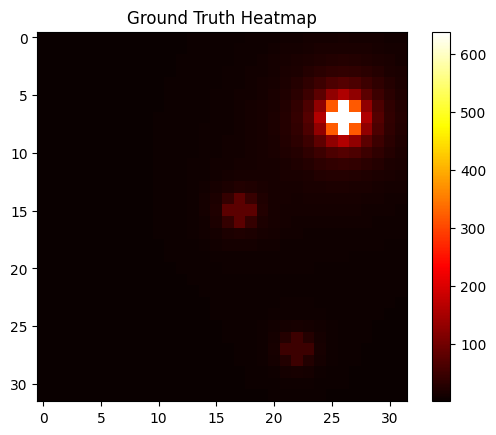

In [145]:
test_index = 12
print(Ys[test_index].max(), Xs[test_index].max())

plt.imshow(Ys[test_index], cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

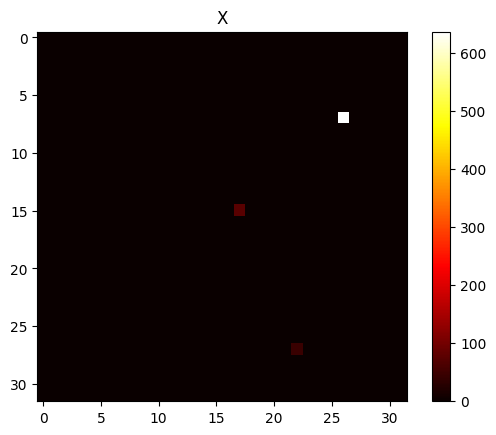

In [146]:
plt.imshow(Xs[test_index], cmap='hot', interpolation='nearest')
plt.title("X")
plt.colorbar()
plt.show()

In [147]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras import activations
from tensorflow.keras.initializers import GlorotUniform
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LeakyReLU

def build_model_leaky(n_inputs, hidden_layers=[10, 10, 10], n_out=1, dropout=0., alpha=0.3):
    """
    builds a neural network using the depth and layer sizes provided by hidden_layers arg
    choose an activation function from the supported functions in activations
    
    when Keras initializes the weights and biases, they're set to random values, this can 
    cause each instance of the model to perform radically differently 
    
    As such, when we compare the results for different epochs, normalization, etc. the 
    weights and biases should be set using the same seed and initializer
    """
    initializer = GlorotUniform(seed=808)
    
    model = Sequential()
    for i, layer in enumerate(hidden_layers):
        if i == 0:
            # define the input shape based on n_inputs
            model.add(Dense(hidden_layers[i], input_shape=(n_inputs,), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
        else:
            model.add(Dropout(dropout))
            model.add(BatchNormalization())
            # base the input shape on the previous layer
            model.add(Dense(hidden_layers[i], input_shape=(hidden_layers[i-1],), kernel_initializer=initializer))
            model.add(LeakyReLU(alpha = alpha))
    
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    # add our output layer
    model.add(Dense(n_out, input_shape=(hidden_layers[len(hidden_layers)-1],), kernel_initializer=initializer))
    
    # build the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

In [148]:
# test the model builder function and use model.summary to verify the shapes we expect from this test
test_model = build_model_leaky(heatmap_w*heatmap_h, [1024, 1024, 2048], n_out=heatmap_w*heatmap_h)

# show the model summary
test_model.summary()

# also, verify the input / output shapes since model.summary only shows outputs
for i, layer in enumerate(test_model.layers):
    print("Layer {0} input shape: {1} output shape:{2}".format(i+1, layer.input_shape[1], layer.output_shape[1]))

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 1024)              0         
                                                                 
 dropout_24 (Dropout)        (None, 1024)              0         
                                                                 
 batch_normalization_24 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_35 (Dense)            (None, 1024)              1049600   
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 1024)              0         
                                                     

In [149]:
Xs_reshaped = Xs.reshape((num_heatmaps, heatmap_w*heatmap_h))
ys_reshaped = Ys.reshape((num_heatmaps, heatmap_w*heatmap_h))

In [150]:
X_train, X_test, y_train, y_test = train_test_split(Xs_reshaped, ys_reshaped, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7987, 1024) (7987, 1024)
(1997, 1024) (1997, 1024)


In [161]:
n_epochs = 100
hidden_layers = [8192, 8192]
batch_size = 300
alpha = 0.2

best_model_name = 'best_linear_dispersion_model.h5'

# saving the best model weights
checkpoint = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
# note that dropout is essentially disabled by default
model = build_model_leaky(heatmap_w*heatmap_h, hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint],
                    verbose=1)

Epoch 1/100
22/27 [=======================>......] - ETA: 0s - loss: 6243.0972 - mean_squared_error: 6243.0972
Epoch 1: val_loss improved from inf to 7437.53027, saving model to best_linear_dispersion_model.h5
27/27 [==============================] - 2s 51ms/step - loss: 6029.9707 - mean_squared_error: 6029.9707 - val_loss: 7437.5303 - val_mean_squared_error: 7437.5303
Epoch 2/100
25/27 [==========================>...] - ETA: 0s - loss: 4246.9917 - mean_squared_error: 4246.9917
Epoch 2: val_loss improved from 7437.53027 to 4421.30420, saving model to best_linear_dispersion_model.h5
27/27 [==============================] - 1s 47ms/step - loss: 4214.3613 - mean_squared_error: 4214.3613 - val_loss: 4421.3042 - val_mean_squared_error: 4421.3042
Epoch 3/100
24/27 [=========================>....] - ETA: 0s - loss: 3066.7588 - mean_squared_error: 3066.7588
Epoch 3: val_loss improved from 4421.30420 to 3055.88818, saving model to best_linear_dispersion_model.h5
27/27 [=========================

In [162]:
preds = model.predict(X_test)

63/63 [==============================] - 0s 894us/step


In [163]:
print(preds[20].shape)

(1024,)


In [164]:
def plot_compare_heatmaps(original, predicted):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot original heatmap
    im1 = axes[0].imshow(original, cmap='viridis', origin='lower')
    axes[0].set_title("Original Intensity")
    fig.colorbar(im1, ax=axes[0])

    # Plot predicted heatmap
    im2 = axes[1].imshow(predicted, cmap='viridis', origin='lower')
    axes[1].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[1])

    plt.tight_layout()
    plt.show()

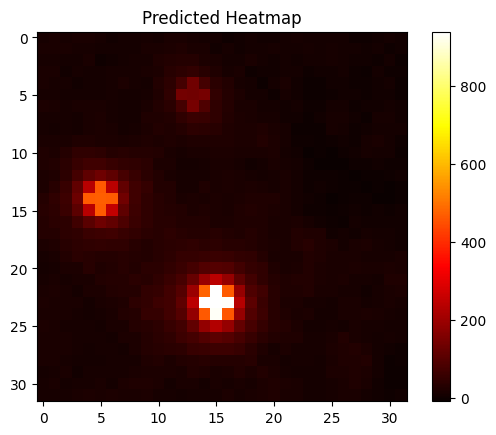

In [165]:
plt.imshow(preds[20].reshape(heatmap_w, heatmap_h), cmap='hot', interpolation='nearest')
plt.title("Predicted Heatmap")
plt.colorbar()
plt.show()

In [166]:
def plot_compare_heatmaps(input, original, predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 5))

    # Plot original heatmap
    im0 = axes[0].imshow(input, cmap='plasma', origin='lower')
    axes[0].set_title("Sparse input")
    fig.colorbar(im0, ax=axes[0])

    # Plot original heatmap
    im1 = axes[1].imshow(original, cmap='plasma', origin='lower')
    axes[1].set_title("Simulated Intensity")
    fig.colorbar(im1, ax=axes[1])

    # Plot predicted heatmap
    im2 = axes[2].imshow(predicted, cmap='plasma', origin='lower')
    axes[2].set_title("Predicted Intensity")
    fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

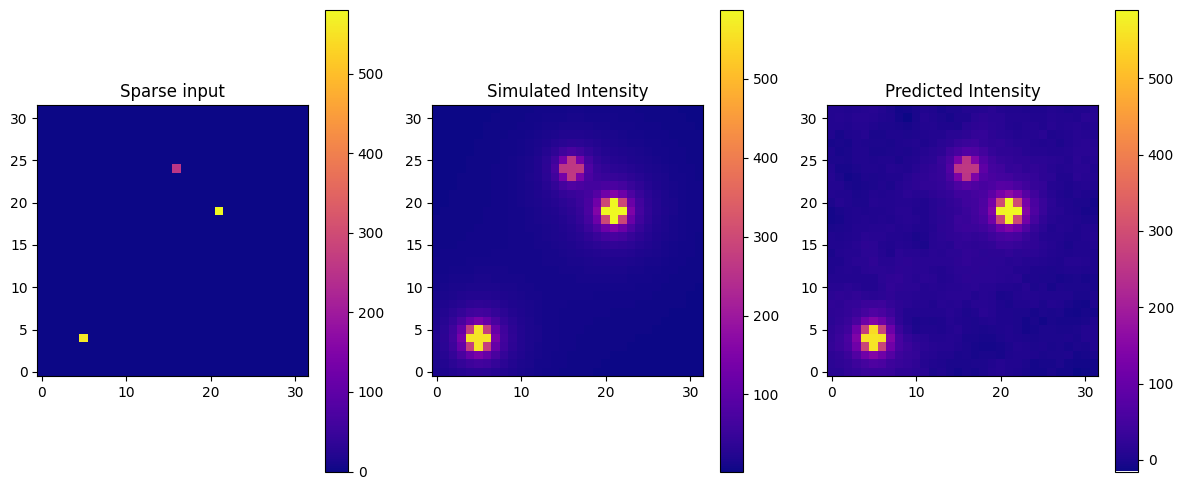

In [167]:
plot_compare_heatmaps(X_test[10].reshape((heatmap_w, heatmap_h)), y_test[10].reshape((heatmap_w, heatmap_h)), preds[10].reshape((heatmap_w,heatmap_h)))

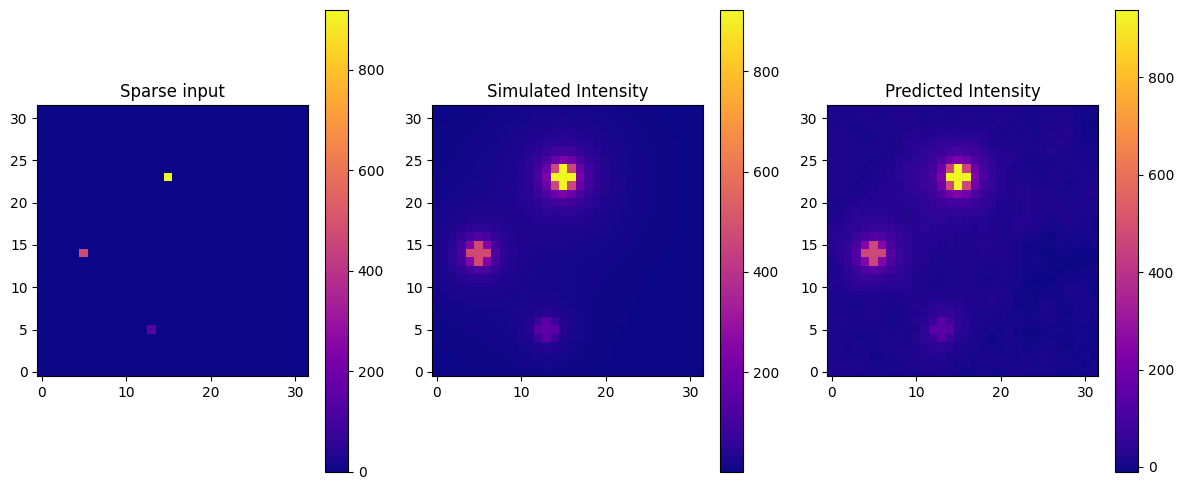

In [168]:
plot_compare_heatmaps(X_test[20].reshape((heatmap_w, heatmap_h)), y_test[20].reshape((heatmap_w, heatmap_h)), preds[20].reshape((heatmap_w,heatmap_h)))

## Can we input arbitrary sources / intensites in our sparse matrix. 

The previous model learned to approximate the 2D heatmap algorithm from a fixed number of sparse inputs but can we input arbitrary number / intensity of sources into this model and have it predict the heatmap?

In [169]:
test_sources = np.array([[600, 2, 5], [800, 10, 20], [100, 15, 15], [600, 22, 22], [600, 2, 20]])
test_sources_sparse = get_sparse_matrix(heatmap_w, heatmap_h, test_sources)
test_sources_flat = test_sources_sparse.reshape((heatmap_w * heatmap_h))

test_Xs = np.zeros((1, heatmap_h * heatmap_w))
test_Xs [0] = test_sources_flat

test_preds = model.predict(test_Xs)

1/1 [==============================] - 0s 10ms/step


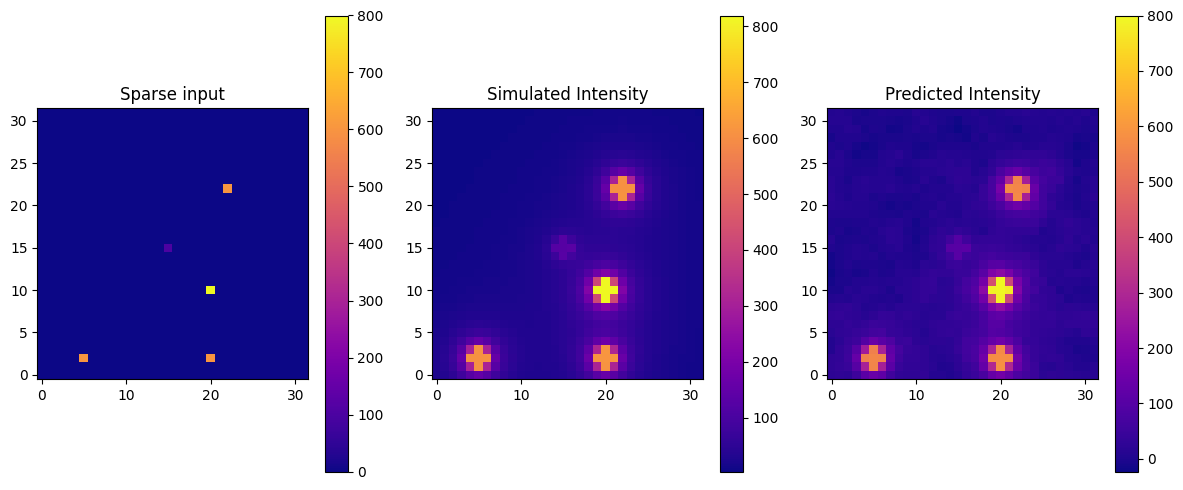

In [170]:
test_Yhat = test_preds[0].reshape((heatmap_w, heatmap_h))

plot_compare_heatmaps(test_sources_sparse, intensity_matrix(heatmap_w, heatmap_h, test_sources), test_Yhat)

This is great, it does work, but again, the low intensity sources are noisy and the background is noisy. It's likley we need to standardize the input and/or adjust the architecture. With that said, this form of network is not optimal. We'll a) want to see if we can capture the spatial positions as features and b) create CNN and/or other generative forms. 

# "Dense" Version

Instead of a sparse matrix as input, the network may learn better where the input matrix contains the source x,y,intensity values as features. However, coming up with an embedding solution for *N* number of dense inputs (*N* sources) will be an exercise for the near future. For now, we'll focus on building a dense input with fixed number of sources and determine if using the x,y location as a feature helps learn the spatial relationships better. 

In [173]:
def generate_dataset_dense(m, n, num_heatmaps=1000, n_sources=4):

    sources = np.zeros((n_sources, 3))

    intensity_range = (0,10)

    heatmap_matrices = np.zeros((num_heatmaps, m, n))
    dense_matrices = np.zeros((num_heatmaps, sources.shape[0] * sources.shape[1]))

    # build num_heatmaps
    for i in range(num_heatmaps):
        # randomize the intensities and / or source positions
        for k in range(n_sources):
            
            intensity = random.uniform(intensity_range[0], intensity_range[1])
            sources[k][0] = intensity
            
            # randomize the source position as well
            source_x = random.uniform(0, m)
            source_y = random.uniform(0, n)
            
            sources[k][1] = int(source_x)
            sources[k][2] = int(source_y)

        heatmap_matrices[i] = intensity_matrix(m, n, sources)
        dense_matrices[i] = sources.flatten()
        
    return dense_matrices, heatmap_matrices

In [174]:
n_heatmaps_dense = 1000

Xs_dense, Ys_dense = generate_dataset_dense(heatmap_w, heatmap_h, num_heatmaps=n_heatmaps_dense)

In [175]:
print(Xs_dense.shape, Ys_dense.shape)

(1000, 12) (1000, 32, 32)


In [176]:
print(Xs_dense[0])

[ 9.95539986 21.          9.          9.2696229   9.         17.
  7.23939492 31.         27.          3.8190542   6.         10.        ]


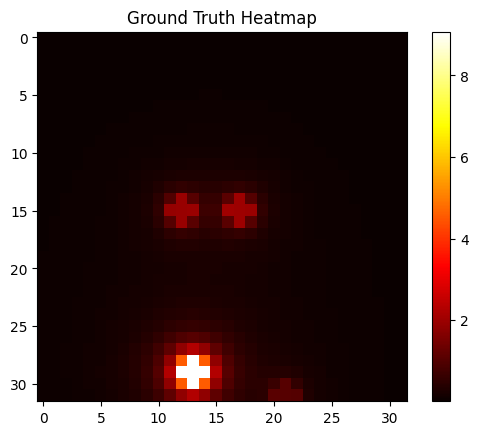

In [177]:
plt.imshow(Ys_dense[100], cmap='hot', interpolation='nearest')
plt.title("Ground Truth Heatmap")
plt.colorbar()
plt.show()

In [178]:
ys_reshaped_dense = Ys_dense.reshape((n_heatmaps_dense, heatmap_w*heatmap_h))

In [179]:
X_train_dense, X_test_dense, y_train_dense, y_test_dense = train_test_split(Xs_dense, ys_reshaped_dense, test_size=0.2, random_state=42)

print(X_train_dense.shape, y_train_dense.shape)
print(X_test_dense.shape, y_test_dense.shape)

(800, 12) (800, 1024)
(200, 12) (200, 1024)


In [180]:
n_epochs = 100
hidden_layers = [1024, 1024, 1024, 1024]
batch_size = 32
alpha = 0.2

best_model_name = 'best_linear_dispersion_model_dense.h5'

# saving the best model weights
checkpoint_dense = ModelCheckpoint(best_model_name, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='min'
)  

# build the model
# note that dropout is essentially disabled by default
model_dense = build_model_leaky(X_train_dense.shape[1], hidden_layers, n_out=heatmap_w*heatmap_h, alpha=alpha)

# fit the model
history = model_dense.fit(X_train_dense, y_train_dense, 
                    validation_data=(X_test_dense, y_test_dense), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    callbacks=[checkpoint_dense],
                    verbose=1)

Epoch 1/100
 1/25 [>.............................] - ETA: 34s - loss: 2.1074 - mean_squared_error: 2.1074
Epoch 1: val_loss improved from inf to 5.39724, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 2s 8ms/step - loss: 1.2391 - mean_squared_error: 1.2391 - val_loss: 5.3972 - val_mean_squared_error: 5.3972
Epoch 2/100
19/25 [=====================>........] - ETA: 0s - loss: 0.9759 - mean_squared_error: 0.9759
Epoch 2: val_loss improved from 5.39724 to 3.14309, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 0s 5ms/step - loss: 0.9630 - mean_squared_error: 0.9630 - val_loss: 3.1431 - val_mean_squared_error: 3.1431
Epoch 3/100
 1/25 [>.............................] - ETA: 0s - loss: 0.8552 - mean_squared_error: 0.8552
Epoch 3: val_loss improved from 3.14309 to 1.86218, saving model to best_linear_dispersion_model_dense.h5
25/25 [==============================] - 0s 4ms/step - loss: 0.8763 - me

In [182]:
preds_dense = model_dense.predict(X_test_dense)

7/7 [==============================] - 0s 831us/step


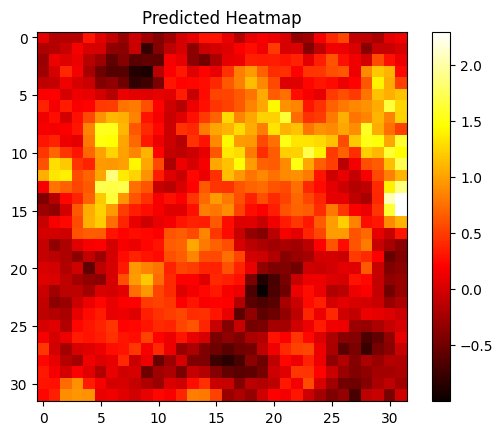

In [183]:
plt.imshow(preds_dense[20].reshape(heatmap_w, heatmap_h), cmap='hot', interpolation='nearest')
plt.title("Predicted Heatmap")
plt.colorbar()
plt.show()